# Stochastic Processes Project

Jean Duboscq, Keshav Ganesh, Daniyar Zakarin

## Project 10:

Description:  Escape of a particle from an intracellular region: A particle is diffusing according to Brownian motion in a 2D circular domain of radius $r$. The particle can only exit the domain from an opening defined by a segment of a circle of angular width $\theta$.

We investigate the mean exit time of the domain as a function of the angular width $\theta$.

## General Imports

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import sys
import datetime
from scipy.stats import linregress


### Basic Implementation

Here, we fix the radius of the circle to be 1 and the diffusion coefficient to be 1. We will use the following parameters for the simulation:

- $r = 1$
- $D = 1$
- $x_0 = (0, 0)$

In the following code, we set $\theta$ to be $\pi$/4, just to see general behavior of the particles.

In [36]:
class Experiment:
    def __init__(self, r = 1.0, theta = np.pi / 4, 
                 D = 1.0, dt = 0.01, num_particles = 10000, 
                 x_start = 0.0, y_start = 0.0, T_lim = 10000.):
        self.r = r # radius of the circle
        self.theta = theta # exit angular width
        self.D = D # diffusion constant
        self.dt = dt # number of particles to simulate
        self.num_particles = num_particles # number of particles to simulate
        self.x_start = x_start # starting x coordinate
        self.y_start = y_start # starting y coordinate
        self.T_lim = T_lim
E = Experiment

In [70]:
# Parameters
default_experiment = E(
    r = 1.0, 
    theta = np.pi / 4, 
    D = 1.0, 
    dt = 0.01, 
    num_particles = 10000, 
    x_start = 0.0, 
    y_start = 0.0
)

In [6]:
def is_in_exit_segment(x, y, theta):
    angle = np.arctan2(y, x)
    return -theta/2 <= angle <= theta/2

Here we write a function to reflect the particle off the boundary of the circle. This only occurs if at any point the particle is outside the circle in the angular region which is not the opening.

In [254]:
def reflect(x, y, x_prev, y_prev, r):
    # Calculate the coefficients of the quadratic equation
    dx = x - x_prev
    dy = y - y_prev
    a = dx**2 + dy**2
    b = 2 * (x_prev * dx + y_prev * dy)
    c = x_prev**2 + y_prev**2 - r**2
    
    discriminant = b**2 - 4 * a * c
    
    if discriminant < 0:
        raise ValueError("Discriminant is negative. Check the input values.")
    
    sqrt_discriminant = np.sqrt(discriminant)
    
    t1 = (-b + sqrt_discriminant) / (2 * a)
    t2 = (-b - sqrt_discriminant) / (2 * a)
    
    # Select the correct intersection point
    t = None
    if 0 <= t1 <= 1:
        t = t1
    elif 0 <= t2 <= 1:
        t = t2
    if t is None:
        raise ValueError("Both intersection points are out of bounds.")
    
    x_intersection = x_prev + t * dx
    y_intersection = y_prev + t * dy
    
    # Calculate the normal vector at the intersection point
    normal_x = x_intersection / r
    normal_y = y_intersection / r
    
    # Calculate the incident vector
    incident_x = x - x_intersection
    incident_y = y - y_intersection
    
    # Reflect the incident vector across the normal vector
    dot_product = incident_x * normal_x + incident_y * normal_y
    reflection_x = incident_x - 2 * dot_product * normal_x
    reflection_y = incident_y - 2 * dot_product * normal_y
    
    # Calculate the reflected position
    x_reflection = x_intersection + reflection_x
    y_reflection = y_intersection + reflection_y
    
    return x_reflection, y_reflection

def brownian_step_escaped(x, y, experiment):
    x_prev, y_prev = x, y
    D = experiment.D
    dt = experiment.dt
    theta = experiment.theta 
    r = experiment.r
    
    # Brownian motion: update position with random steps
    step_size = np.sqrt(2 * D * dt)
    dx = step_size * np.random.randn()
    dy = step_size * np.random.randn()
    x_new = x + dx
    y_new = y + dy

    # Check if particle is outside the circle
    if x_new**2 + y_new**2 <= r**2:
        if is_in_exit_segment(x_new, y_new, theta):
            x, y = x_new, y_new
        else:
            # Reflect the particle back
            try:
                x, y = reflect(x_new, y_new, x, y, r)
            except ValueError:
                # Handle the case where reflection calculation fails
                x, y = x_prev, y_prev  # Reset to previous position
    else:
        x, y = x_new, y_new

    return x, y

def brownian_step(x, y, experiment):
    x_prev, y_prev = x, y
    D = experiment.D
    dt = experiment.dt
    theta = experiment.theta 
    r = experiment.r
    
    # Brownian motion: update position with random steps
    step_size = np.sqrt(2 * D * dt)
    dx = step_size * np.random.randn()
    dy = step_size * np.random.randn()
    x_new = x + dx
    y_new = y + dy
    
    # Check if particle is outside the circle
    if x_new**2 + y_new**2 > r**2:
        if is_in_exit_segment(x_new, y_new, theta):
            x, y = x_new, y_new
        else:
            # Reflect the particle back
            try:
                x, y = reflect(x_new, y_new, x, y, r)
            except ValueError:
                # Handle the case where reflection calculation fails
                x, y = x_prev, y_prev  # Reset to previous position
    else:
        x, y = x_new, y_new
    return x, y

In [89]:
def simulate_particle(experiment):
    # Start at the center
    x, y = experiment.x_start, experiment.y_start
    time = 0.0
    
    D = experiment.D 
    dt = experiment.dt
    theta = experiment.theta 
    r = experiment.r 

    while time < experiment.T_lim:
        x, y = brownian_step(x, y, experiment)  
        time += dt
        if x**2 + y**2 > r**2:      
            return time
    return None

In [81]:
mean_exit_times = [simulate_particle(default_experiment) for _ in range(default_experiment.num_particles)]
mean_exit_time = np.mean(mean_exit_times)
print(f"Mean exit time (discretized with Brownian motion and elastic reflection): {mean_exit_time}")

Mean exit time (discretized with Brownian motion and elastic reflection): 2.2279219999999818


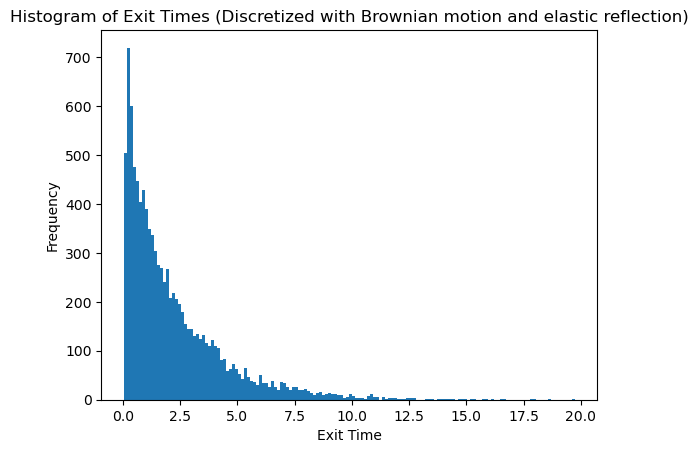

In [83]:
# Plot histogram of exit times
plt.hist(mean_exit_times, bins=150)
plt.xlabel('Exit Time')
plt.ylabel('Frequency')
plt.title('Histogram of Exit Times (Discretized with Brownian motion and elastic reflection)')
plt.show()

Now, we alter the parameter $\theta$ to see how the mean exit time changes.

In [84]:
def mean_exit_time_theta(experiment):
    x_start = experiment.x_start
    y_start = experiment.y_start 
    theta = experiment.theta
    num_particles = experiment.num_particles 
    
    mean_exit_times = [simulate_particle(E(theta=theta, x_start=x_start, y_start=y_start)) for _ in range(num_particles)]
    mean_exit_time = np.mean(mean_exit_times)
    return mean_exit_time

Time taken to run simulation with different theta values: 46.916893005371094 seconds
[4.559392999999962, 3.1585609999999686, 2.5925729999999763, 2.1971969999999823, 1.8755039999999874, 1.6804929999999898, 1.4905769999999925, 1.348199999999994, 1.228707999999995, 1.1147989999999968, 0.9946919999999975, 0.9135669999999982, 0.8438169999999987, 0.7605149999999993, 0.6971129999999995, 0.6559139999999998, 0.5954899999999997, 0.547016, 0.5137550000000001, 0.4822190000000001, 0.4534830000000002, 0.41135300000000014, 0.38499600000000017, 0.36565800000000015, 0.34569400000000017, 0.3343200000000001, 0.32159900000000013, 0.3053560000000001, 0.3043620000000002, 0.29693100000000017]
[0.19634954 0.40624043 0.61613132 0.82602221 1.03591309 1.24580398
 1.45569487 1.66558576 1.87547665 2.08536754 2.29525843 2.50514931
 2.7150402  2.92493109 3.13482198 3.34471287 3.55460376 3.76449465
 3.97438553 4.18427642 4.39416731 4.6040582  4.81394909 5.02383998
 5.23373086 5.44362175 5.65351264 5.86340353 6.073294

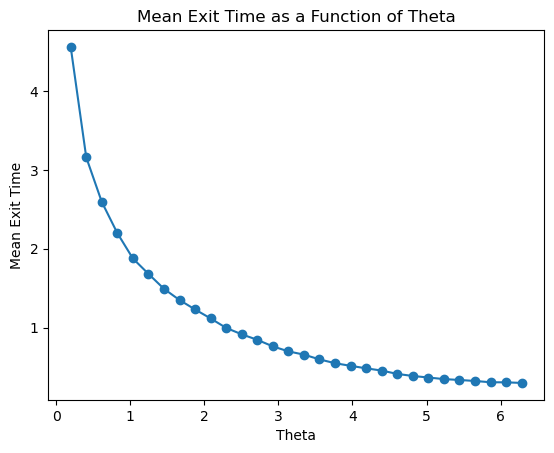

In [85]:
# run simulation with different theta values

theta_values = np.linspace(np.pi/16, 2*np.pi, 30)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

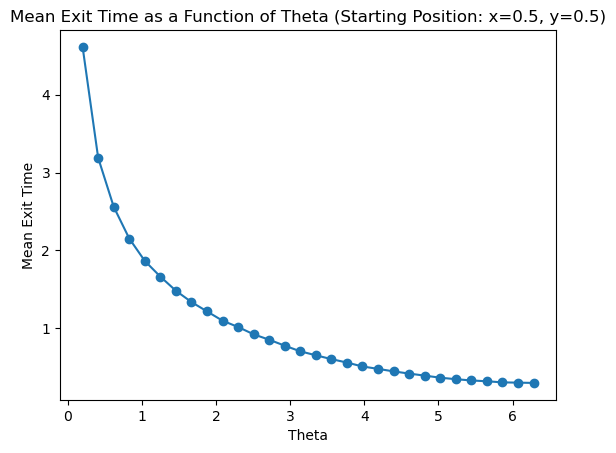

In [86]:
# change starting position of particles
mean_exit_times_theta_list = []
for theta in theta_values:
    experiment = Experiment(theta = theta, num_particles = 10000, x_start = 0.5, y_start = 0.5)
    mean_exit_times_theta_list.append(mean_exit_time_theta(experiment))

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta (Starting Position: x=0.5, y=0.5)')
plt.show()

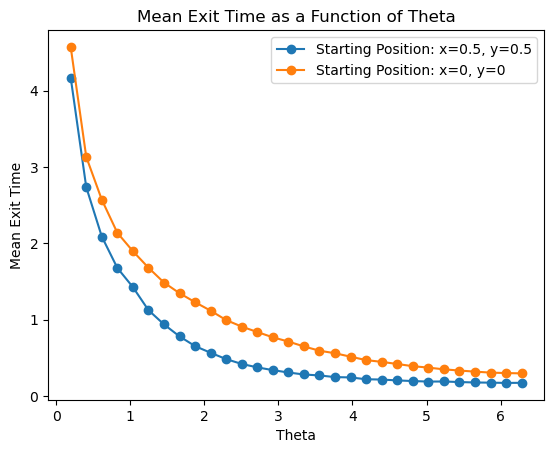

In [262]:
# plot both curves

mean_exit_times_theta_list_moved = [mean_exit_time_theta(E(theta = theta, num_particles=10000, x_start=0.5, y_start=0.5)) for theta in theta_values]
mean_exit_times_theta_list = [mean_exit_time_theta(E(theta=theta, num_particles=10000)) for theta in theta_values]

plt.plot(theta_values, mean_exit_times_theta_list_moved, marker='o', label='Starting Position: x=0.5, y=0.5')
plt.plot(theta_values, mean_exit_times_theta_list, marker='o', label='Starting Position: x=0, y=0')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.legend()
plt.show()

We try to fit this function to the mean exit time function
\begin{equation}
T(\theta) = \beta e^{\alpha / \theta}
\end{equation}

In [271]:
def fit_min_exit_time_to_exp(theta_vals, mean_exit_time_vals):
    my_theta_vals = np.array(theta_vals)
    my_mean_exit_time_vals = np.array(mean_exit_time_vals)

    x = 1 / my_theta_vals
    y = np.log(my_mean_exit_time_vals)

    # Step 3: Use linregress to find the slope and intercept
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    alpha = slope 
    beta = np.exp(intercept)
    return alpha, beta

0.6083530268701564 0.5192810677166473
Time taken to run simulation with different theta values: 49.34588432312012 seconds
[4.652655999999959, 3.244538999999967, 2.5632949999999766, 2.175579999999983, 1.881732999999987, 1.6848109999999898, 1.4841629999999923, 1.3448729999999942, 1.227317999999995, 1.1157899999999965, 1.0043569999999975, 0.9351009999999981, 0.8392119999999986, 0.7607329999999991, 0.7069919999999995, 0.6456379999999997, 0.6023369999999999, 0.5537040000000001, 0.5071490000000001, 0.47117300000000023, 0.44061900000000026, 0.41995000000000016, 0.39148200000000016, 0.3680220000000001, 0.3490230000000002, 0.33379400000000015, 0.31866900000000004, 0.30339300000000013, 0.3007040000000001, 0.2958450000000001]
[0.19634954 0.40624043 0.61613132 0.82602221 1.03591309 1.24580398
 1.45569487 1.66558576 1.87547665 2.08536754 2.29525843 2.50514931
 2.7150402  2.92493109 3.13482198 3.34471287 3.55460376 3.76449465
 3.97438553 4.18427642 4.39416731 4.6040582  4.81394909 5.02383998
 5.2337

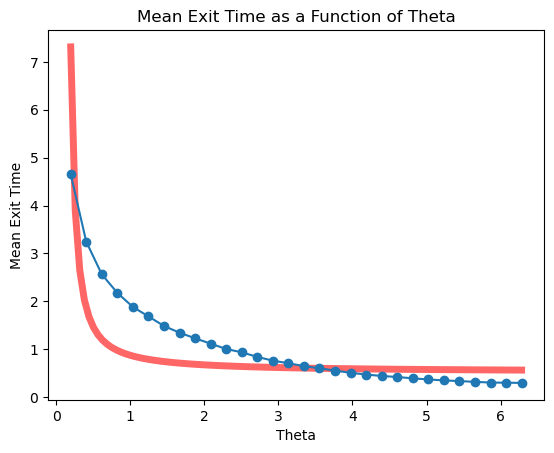

In [276]:
# run simulation with different theta values

theta_values = np.linspace(np.pi/16, 2*np.pi, 30)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

alpha, beta = fit_min_exit_time_to_exp(theta_values, mean_exit_times_theta_list)
print(alpha, beta)
x = np.linspace(np.pi/16, 2*np.pi, 100)
plt.plot(x, beta * np.exp(beta / x),
       'r-', lw=5, alpha=0.6, label='levy pdf')

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

\begin{equation}
    T(\theta) = \beta + \frac{\alpha}{\theta}
\end{equation}

In [284]:
from scipy.optimize import curve_fit

def fit_min_exit_time_to_inv_linear(theta_vals, mean_exit_time_vals):
    my_theta_vals = np.array(theta_vals)
    my_mean_exit_time_vals = np.array(mean_exit_time_vals)

    x = 1 / my_theta_vals
    y = my_mean_exit_time_vals

    # Step 3: Use linregress to find the slope and intercept
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    alpha = slope 
    beta = intercept
    return alpha, beta

def fit_min_exit_time_to_inv_linear_with_curvefit(theta_vals, mean_exit_time_vals):
    def formula(x, alpha, beta):
        return beta + alpha / x
    
    params, covariance = curve_fit(formula, theta_vals, mean_exit_time_vals)
    alpha, beta = params
    return alpha, beta

0.9603724566633827 0.43373437871169873
Time taken to run simulation with different theta values: 49.462323904037476 seconds
[4.630552999999961, 3.1502539999999692, 2.5508549999999772, 2.1572829999999827, 1.9160469999999867, 1.6769069999999902, 1.4898019999999923, 1.3394319999999942, 1.2277189999999951, 1.0880839999999965, 0.9962579999999974, 0.9150159999999982, 0.8438809999999987, 0.7687909999999992, 0.7275759999999994, 0.6497929999999996, 0.6044989999999999, 0.552826, 0.52054, 0.48250200000000015, 0.4421420000000002, 0.4059690000000002, 0.39083500000000015, 0.36682000000000015, 0.3441730000000001, 0.33121000000000017, 0.32054500000000014, 0.3051520000000002, 0.30050100000000013, 0.29565300000000005]
[0.19634954 0.40624043 0.61613132 0.82602221 1.03591309 1.24580398
 1.45569487 1.66558576 1.87547665 2.08536754 2.29525843 2.50514931
 2.7150402  2.92493109 3.13482198 3.34471287 3.55460376 3.76449465
 3.97438553 4.18427642 4.39416731 4.6040582  4.81394909 5.02383998
 5.23373086 5.44362175

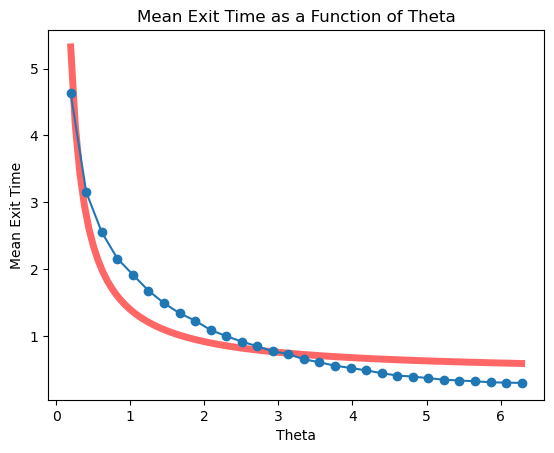

In [282]:
# run simulation with different theta values

theta_values = np.linspace(np.pi/16, 2*np.pi, 30)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

alpha, beta = fit_min_exit_time_to_inv_linear(theta_values, mean_exit_times_theta_list)
print(alpha, beta)
x = np.linspace(np.pi/16, 2*np.pi, 100)
plt.plot(x, beta + alpha / x,
       'r-', lw=5, alpha=0.6, label='levy pdf')

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

Let's use curve_fit method instead

0.9578588725370406 0.4343561065718333
Time taken to run simulation with different theta values: 46.6053671836853 seconds
[4.609769999999962, 3.159815999999968, 2.5647269999999773, 2.159324999999983, 1.8632929999999872, 1.6824189999999901, 1.5045399999999922, 1.358819999999994, 1.2111269999999956, 1.1176969999999964, 0.9915279999999977, 0.9014269999999985, 0.8387399999999987, 0.767757999999999, 0.7138259999999995, 0.6496969999999996, 0.6089059999999997, 0.559756, 0.5181720000000001, 0.4746750000000002, 0.44567300000000015, 0.41586500000000015, 0.38876100000000013, 0.36105700000000013, 0.34853900000000015, 0.32718600000000014, 0.3141080000000001, 0.30303800000000014, 0.30110800000000015, 0.29976400000000014]
[0.19634954 0.40624043 0.61613132 0.82602221 1.03591309 1.24580398
 1.45569487 1.66558576 1.87547665 2.08536754 2.29525843 2.50514931
 2.7150402  2.92493109 3.13482198 3.34471287 3.55460376 3.76449465
 3.97438553 4.18427642 4.39416731 4.6040582  4.81394909 5.02383998
 5.23373086 5.44

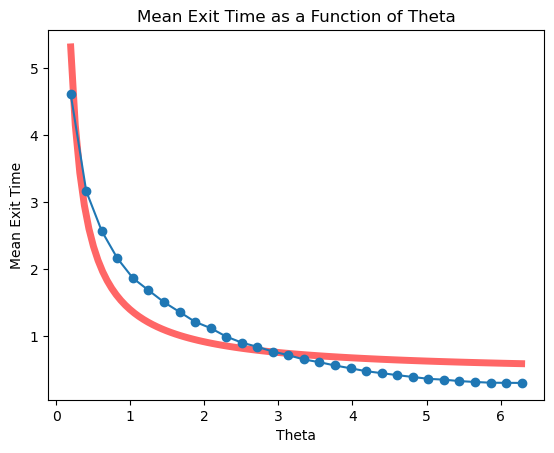

In [285]:
# run simulation with different theta values

theta_values = np.linspace(np.pi/16, 2*np.pi, 30)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

alpha, beta = fit_min_exit_time_to_inv_linear_with_curvefit(theta_values, mean_exit_times_theta_list)
print(alpha, beta)
x = np.linspace(np.pi/16, 2*np.pi, 100)
plt.plot(x, beta + alpha / x,
       'r-', lw=5, alpha=0.6, label='levy pdf')

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

Our hypothesis is that we are overfitting in the region [0, 2pi] and actually if we increase the region to [0, L] for larger L then model will learn the horizontal asymptote better. 

0.9071795699812119 0.275998361034697
Time taken to run simulation with different theta values: 23.885926008224487 seconds
[4.72394999999996, 1.870941999999987, 1.1746759999999958, 0.8239379999999988, 0.586952, 0.4292920000000001, 0.33640800000000015, 0.29547900000000016, 0.2975220000000002, 0.2952000000000001, 0.2963610000000001, 0.29382200000000014, 0.2970170000000001, 0.2959530000000001, 0.29440100000000013, 0.29601900000000014, 0.29523500000000014, 0.2943250000000001, 0.2942960000000001, 0.2925100000000001, 0.2949380000000001, 0.2976540000000001, 0.2936590000000001, 0.2983170000000001, 0.29394200000000015, 0.2938220000000001, 0.29559200000000013, 0.29723900000000014, 0.29468400000000017, 0.3024450000000001]
[ 0.19634954  1.05622512  1.91610069  2.77597627  3.63585184  4.49572742
  5.35560299  6.21547857  7.07535414  7.93522972  8.7951053   9.65498087
 10.51485645 11.37473202 12.2346076  13.09448317 13.95435875 14.81423432
 15.6741099  16.53398547 17.39386105 18.25373663 19.1136122  

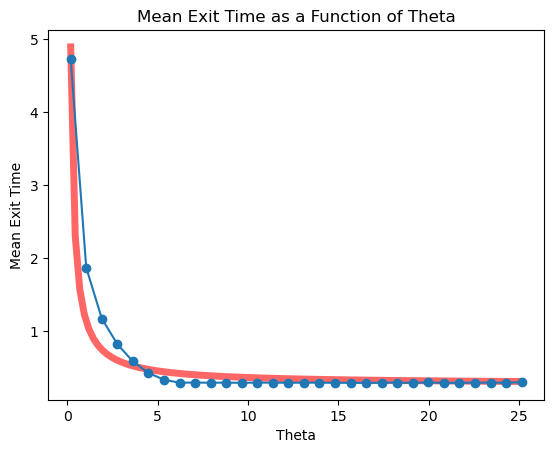

In [287]:
# run simulation with different theta values
L = 8 *np.pi
theta_values = np.linspace(np.pi/16, L, 60)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

alpha, beta = fit_min_exit_time_to_inv_linear_with_curvefit(theta_values, mean_exit_times_theta_list)
print(alpha, beta)
x = np.linspace(np.pi/16, L, 100)
plt.plot(x, beta + alpha / x,
       'r-', lw=5, alpha=0.6, label='levy pdf')

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

0.9393020031843846 0.2755077730370878
Time taken to run simulation with different theta values: 36.72853183746338 seconds
[4.680448999999961, 2.35597799999998, 1.7114829999999892, 1.3117439999999945, 1.0337549999999973, 0.8473549999999989, 0.6761969999999997, 0.565031, 0.47027400000000014, 0.3995010000000002, 0.3416500000000001, 0.30870600000000015, 0.2942590000000001, 0.2953540000000001, 0.2941470000000001, 0.2964810000000001, 0.2926560000000001, 0.29368200000000017, 0.29418100000000014, 0.2932300000000001, 0.2947230000000001, 0.29391100000000003, 0.29388700000000006, 0.29407300000000014, 0.2957760000000001, 0.29615900000000006, 0.29306900000000013, 0.29628000000000004, 0.2981710000000001, 0.2952000000000002, 0.29435300000000014, 0.29304400000000014, 0.29749600000000015, 0.29730600000000007, 0.2950570000000002, 0.2943300000000001, 0.29487600000000014, 0.29607900000000015, 0.2952470000000001, 0.29657400000000017, 0.3025850000000001, 0.29606800000000016, 0.2947410000000001, 0.2941640000

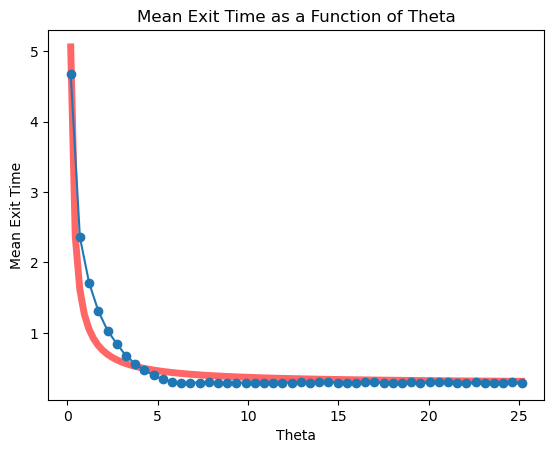

In [288]:
# run simulation with different theta values
L = 8 *np.pi
theta_values = np.linspace(np.pi/16, L, 50)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(E(theta = theta, num_particles=10000)) for theta in theta_values]

alpha, beta = fit_min_exit_time_to_inv_linear_with_curvefit(theta_values, mean_exit_times_theta_list)
print(alpha, beta)
x = np.linspace(np.pi/16, L, 100)
plt.plot(x, beta + alpha / x,
       'r-', lw=5, alpha=0.6, label='levy pdf')

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

# Fitting Levy Distribution to Time Histogram

In [162]:
mean_exit_times_tmp = [simulate_particle(E(r = 1., T_lim = 20.)) for _ in range(10000)]
mean_exit_times_tmp = [val for val in mean_exit_times_tmp if val is not None]
mean_exit_time_tmp = np.mean(mean_exit_times)
print(f"Mean exit time (discretized with Brownian motion and elastic reflection): {mean_exit_time}")

Mean exit time (discretized with Brownian motion and elastic reflection): 2.2279219999999818


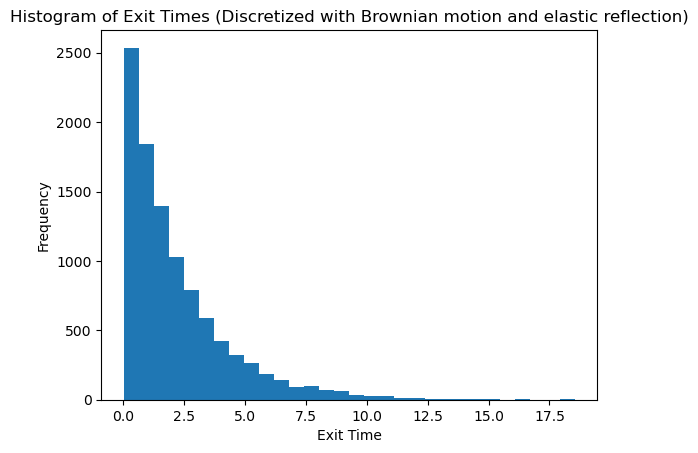

In [163]:
# Plot histogram of exit times
plt.hist(mean_exit_times_tmp, bins=30)
plt.xlabel('Exit Time')
plt.ylabel('Frequency')
plt.title('Histogram of Exit Times (Discretized with Brownian motion and elastic reflection)')
plt.show()

0.7189944278186888 -0.009977055599261802


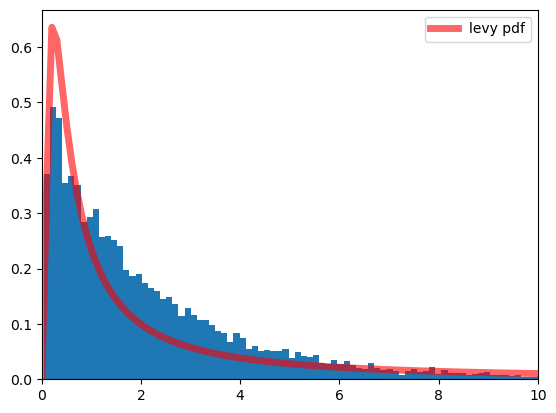

In [166]:
from matplotlib.pylab import norm
from scipy.stats import levy

loc, scale = levy.fit(mean_exit_times_tmp)
print(scale, loc)
x = np.linspace(0, 10, 100)
plt.xlim(0, 10)
plt.plot(x, levy.pdf(x, loc = loc, scale = scale),
       'r-', lw=5, alpha=0.6, label='levy pdf')
plt.hist(mean_exit_times_tmp, bins=150, density = True)
plt.legend()
plt.show()

# Density Plots

In [273]:
# In parallel simulation basically and scatter plot at each step. 

from re import I


def make_snapshot(experiment, coords, escaped_coords, mode = 'scatter'):
    # Parameters
    r = experiment.r  # Radius of the circle
    theta = experiment.r  # Angle of the missing arc in radians (e.g., 45 degrees)
    margin = 0.5

    # Get x and y 
    x = np.array([_[0] for _ in coords])
    y = np.array([_[1] for _ in coords])
    x_esc = np.array([_[0] for _ in escaped_coords])
    y_esc = np.array([_[1] for _ in escaped_coords])
    
    # Create the plot
    fig, ax = plt.subplots()

    if mode == 'scatter':
        # Scatter plot of the points
        ax.scatter(x, y, label='Data points')
        ax.scatter(x_esc, y_esc, label='Escaped data points', color = 'red')
    else: 
        x_full = np.concatenate((x, x_esc))
        y_full = np.concatenate((y, y_esc))
        # Create the heatmap
        heatmap, xedges, yedges = np.histogram2d(x_full, y_full, bins=50, range=[[-r - margin, r + margin], [-r - margin, r + margin]])
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        # Plot the heatmap
        cax = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', aspect='auto')

        # Add a colorbar
        cbar = fig.colorbar(cax, ax=ax)
        cbar.set_label('Frequency')

    # Define the circle with a missing arc
    theta_start = theta / 2.  # Start angle for the arc (in radians)
    theta_end = 2 * np.pi - theta / 2.  # End angle for the arc (in radians)

    # Create the solid arc
    arc_solid = np.linspace(theta_start, theta_end, 100)
    circle_x_solid = r * np.cos(arc_solid)
    circle_y_solid = r * np.sin(arc_solid)

    # Create the dotted arc for the missing segment
    arc_dotted = np.linspace(theta_end, 2 * np.pi + theta_start, 100)
    circle_x_dotted = r * np.cos(arc_dotted)
    circle_y_dotted = r * np.sin(arc_dotted)

    # Plot the solid arc
    ax.plot(circle_x_solid, circle_y_solid, color='y', label=f'Circle with radius {r} and missing arc of {theta * 180 / np.pi:.1f}°')

    # Plot the dotted arc
    ax.plot(circle_x_dotted, circle_y_dotted, 'g--', label='Missing arc')

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Set the limits to create a box from (-r, -r) to (r, r)
    ax.set_xlim(-r - margin, r + margin)
    ax.set_ylim(-r - margin, r + margin)

    # Add grid lines for better visualization
    ax.grid(True)

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

def simulate_particle_with_snapshots(experiment, snapshot_steps, mode = 'scatter'):
    # Start at the center
    coords = [(experiment.x_start, experiment.y_start)] * experiment.num_particles
    escaped_coords = []
    time = 0.0
    step = 0
    max_step = np.max(snapshot_steps)
    
    D = experiment.D 
    dt = experiment.dt
    theta = experiment.theta 
    r = experiment.r 

    while step < max_step:
        new_coords = []
        new_escaped_coords = []
        for (i, (x, y)) in enumerate(escaped_coords):
            x, y = brownian_step_escaped(x, y, experiment)
            escaped_coords[i] = (x, y)
        for (x, y) in coords:
            x, y = brownian_step(x, y, experiment)  
            if x**2 + y**2 <= r**2:      
                new_coords.append((x, y))
            else:
                escaped_coords.append((x, y))
        time += dt
        step += 1
        coords = new_coords
        if step in snapshot_steps:
            make_snapshot(experiment, coords, escaped_coords, mode)
    return None

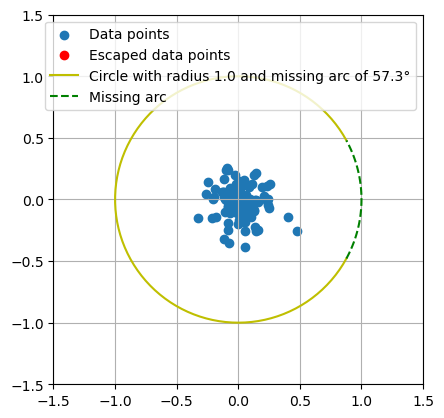

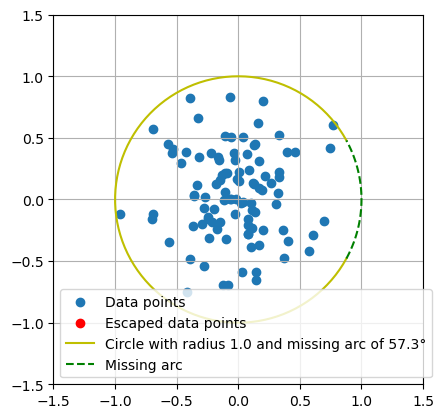

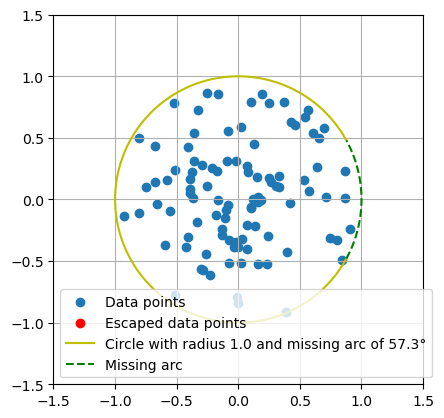

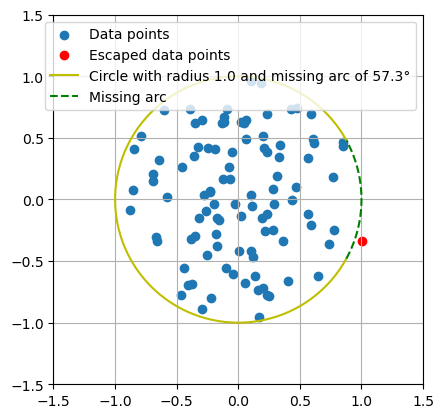

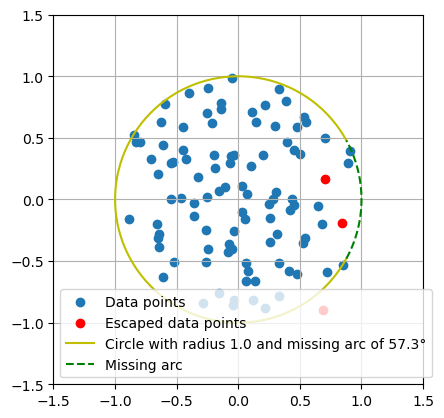

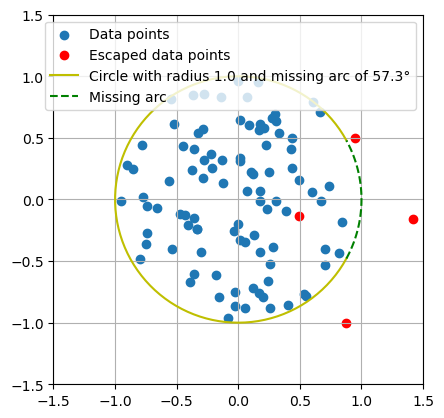

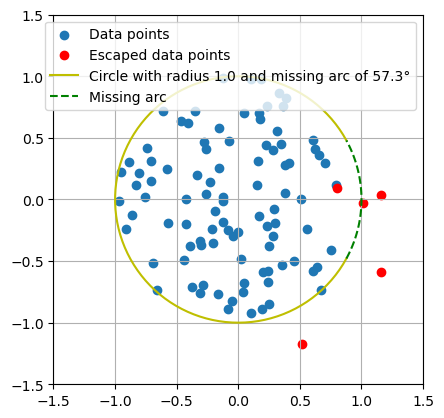

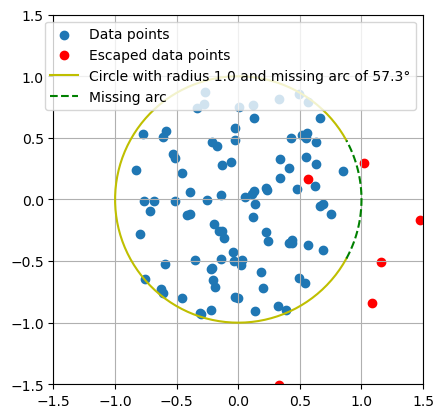

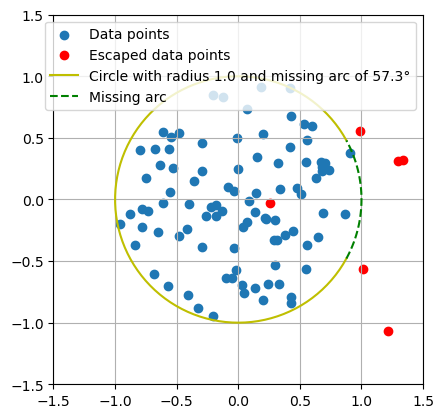

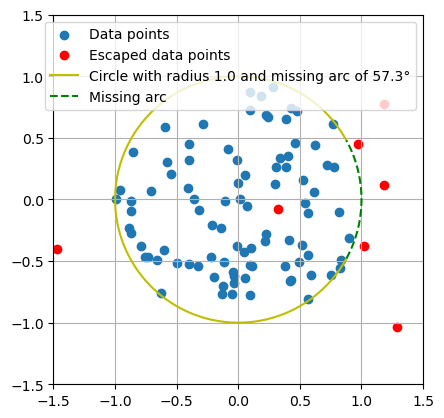

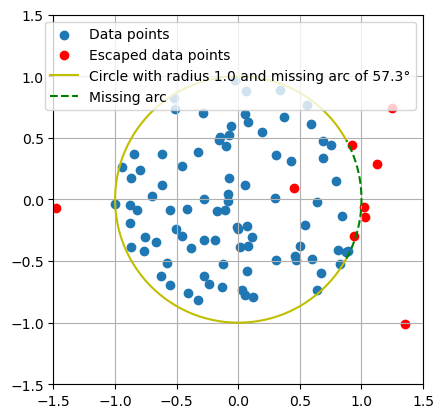

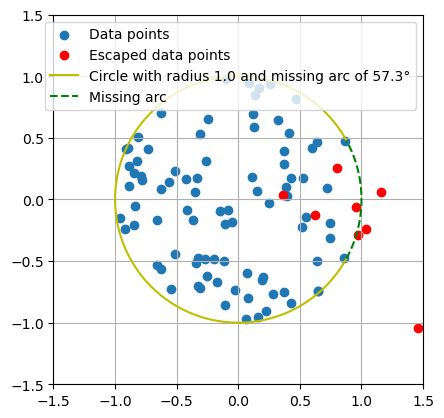

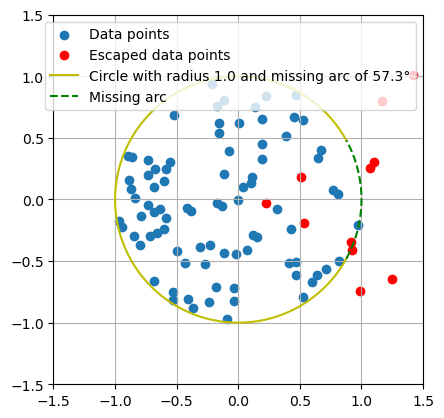

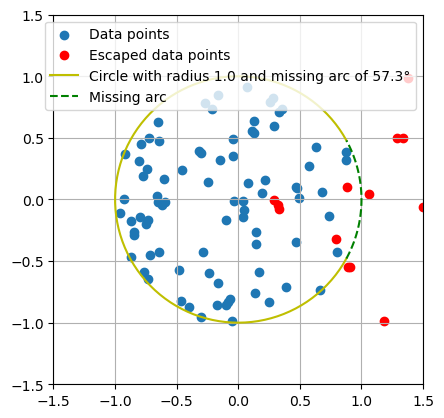

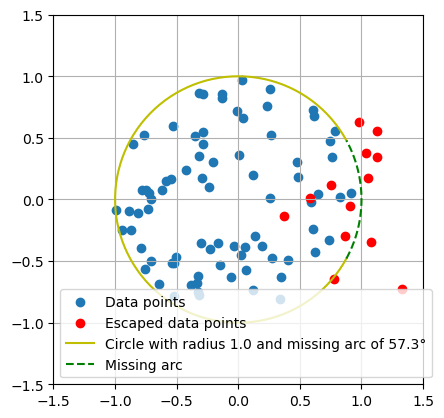

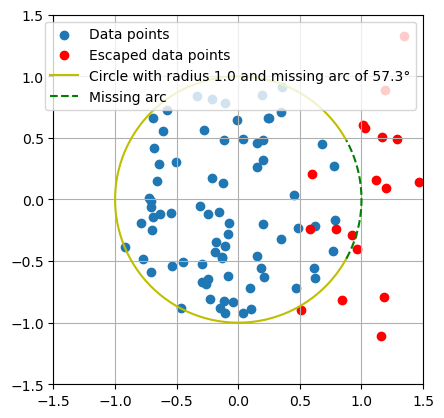

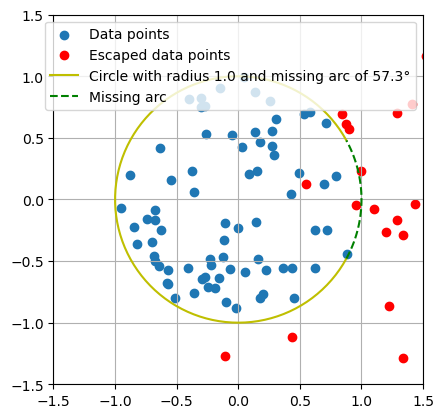

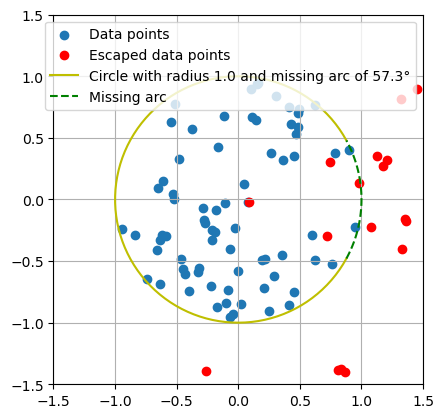

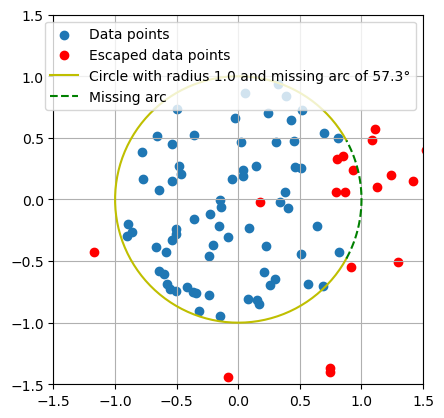

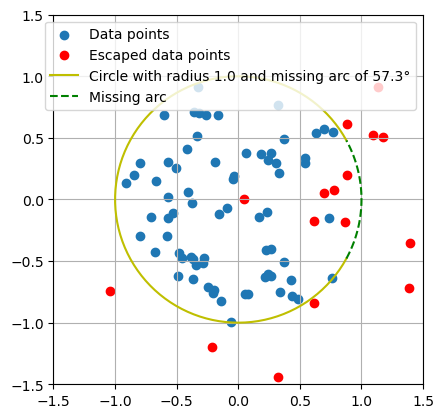

In [274]:
simulate_particle_with_snapshots(E(num_particles=100), range(1, 100, 5))

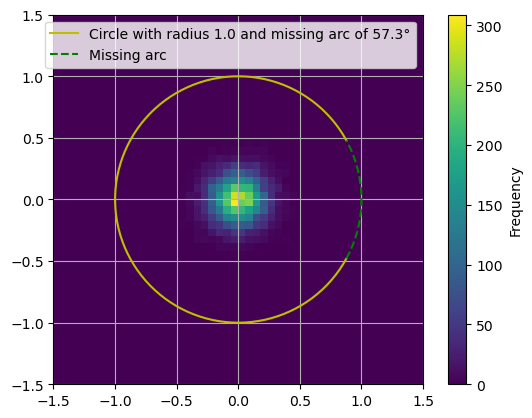

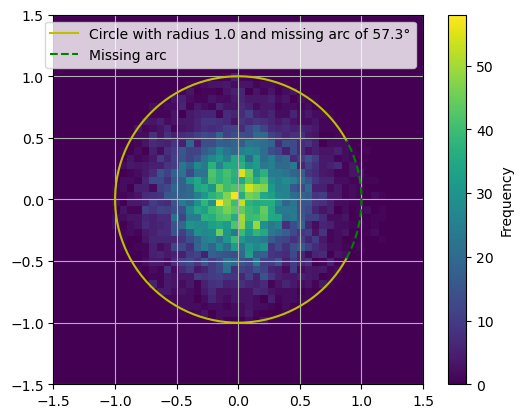

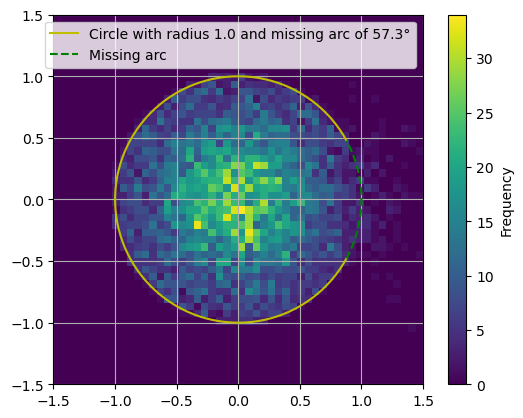

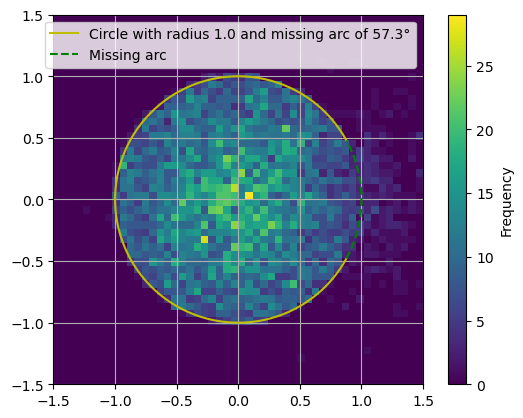

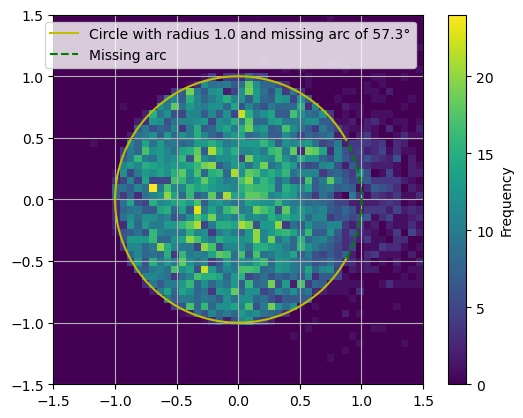

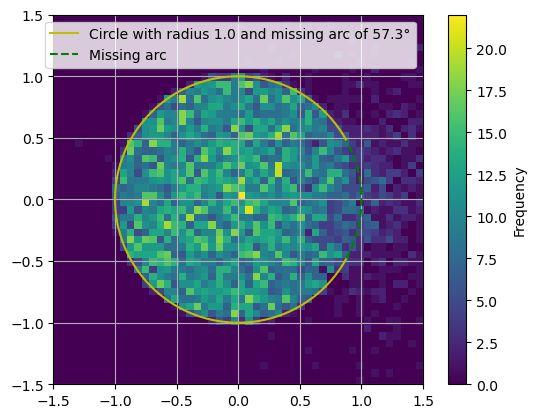

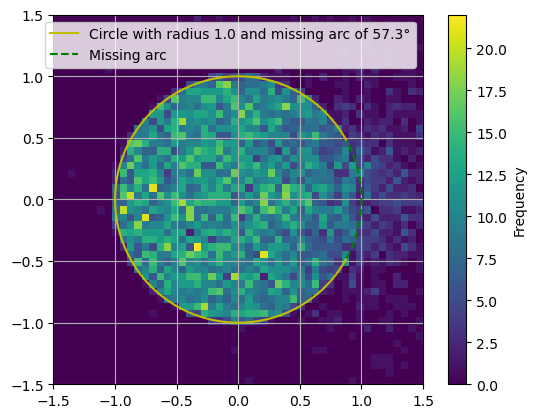

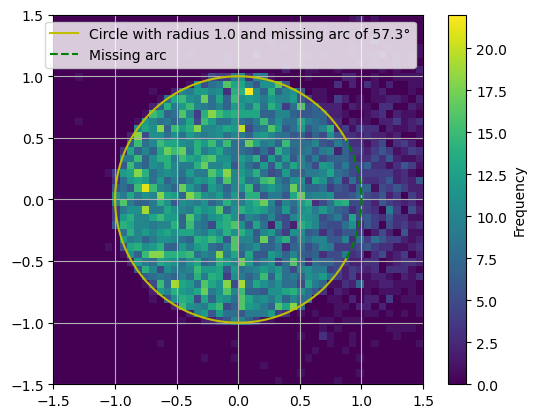

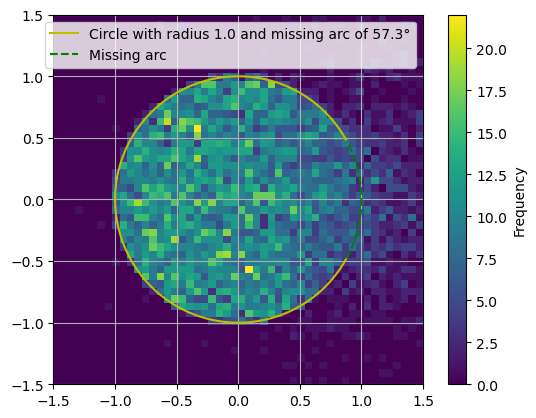

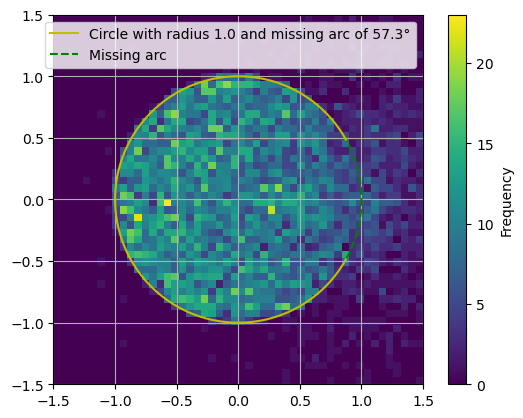

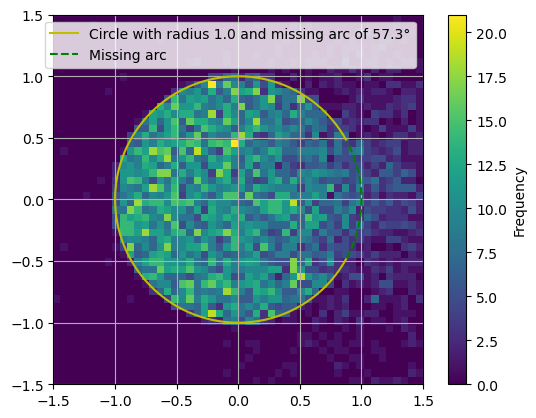

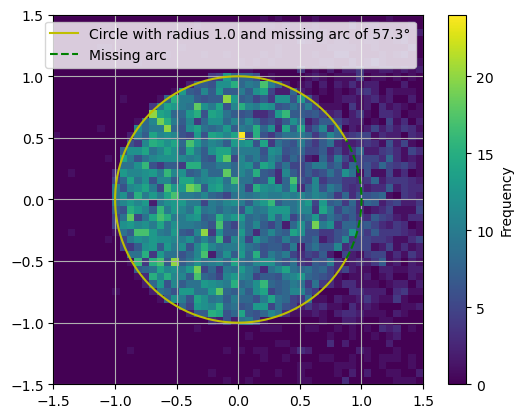

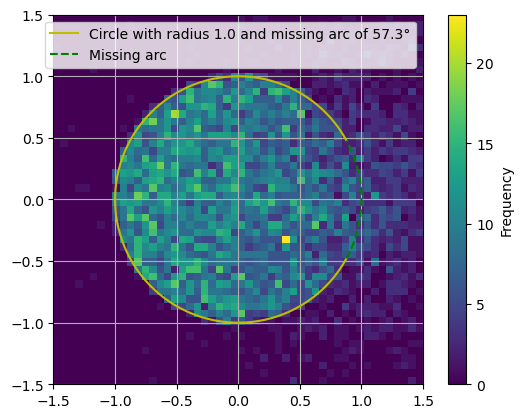

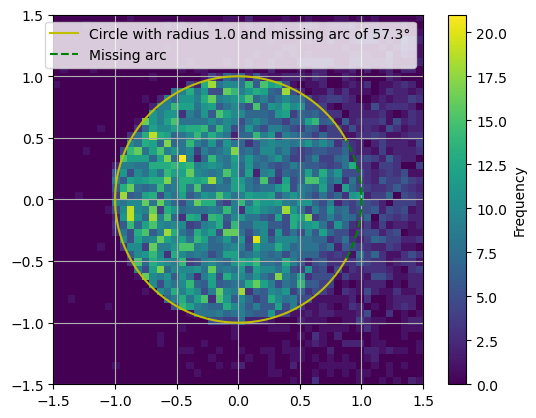

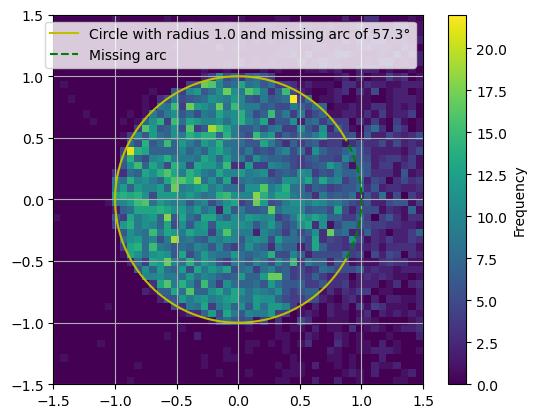

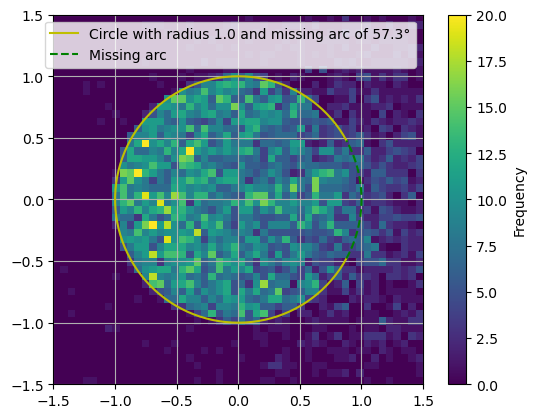

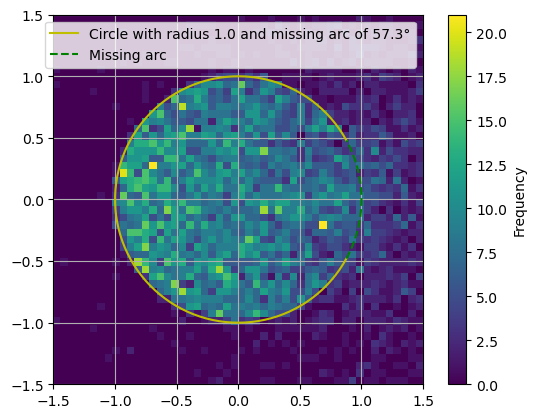

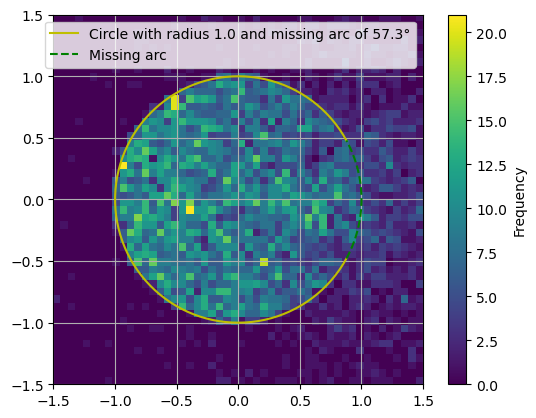

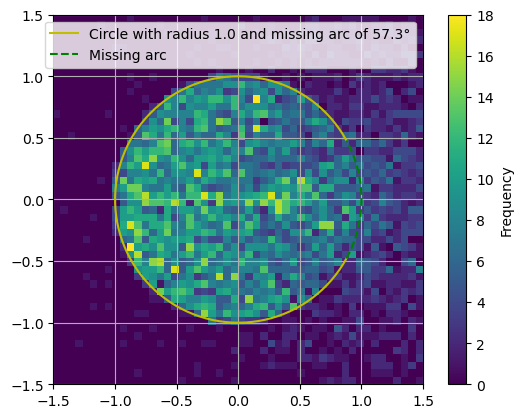

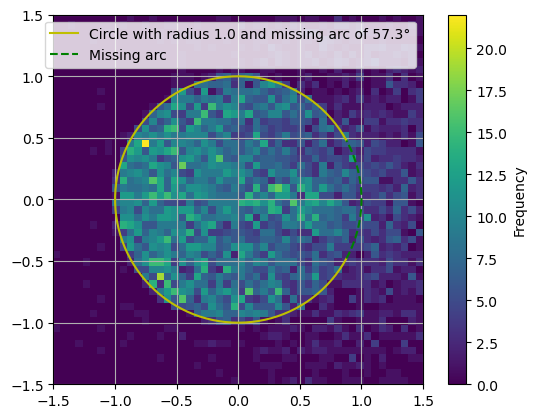

In [275]:
simulate_particle_with_snapshots(E(num_particles=10000), range(1, 100, 5), mode = 'heatmap')

From a position (0.5, 0.5)

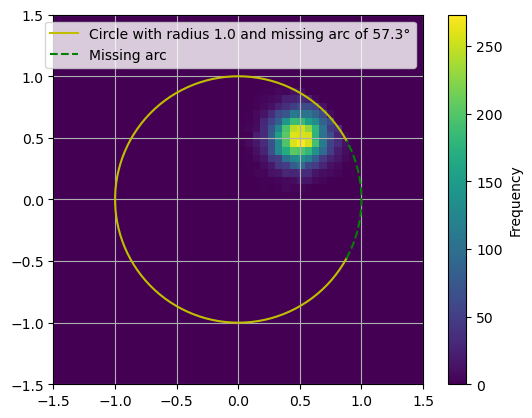

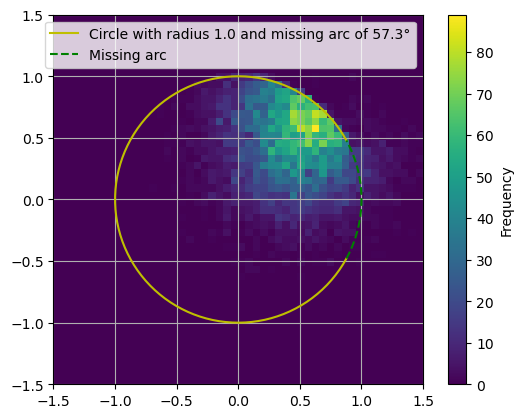

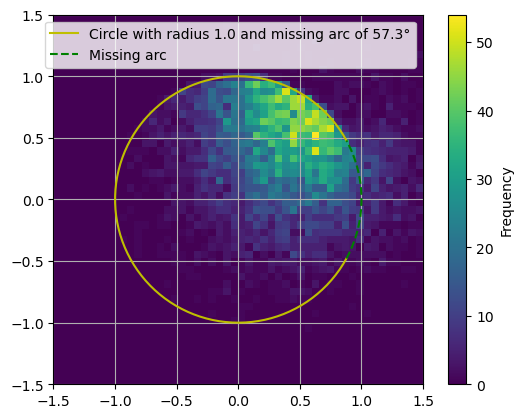

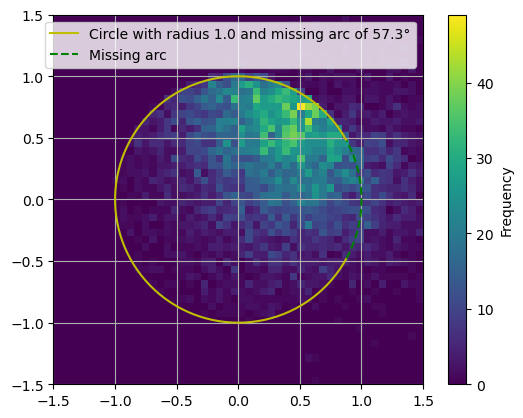

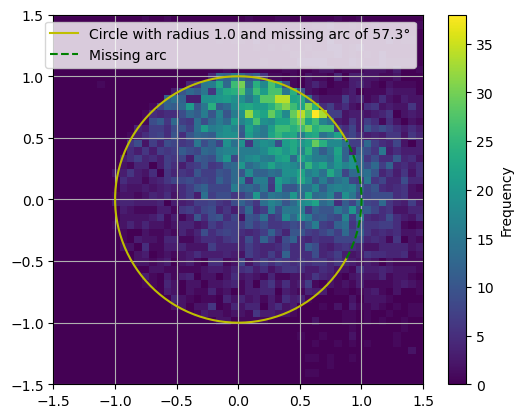

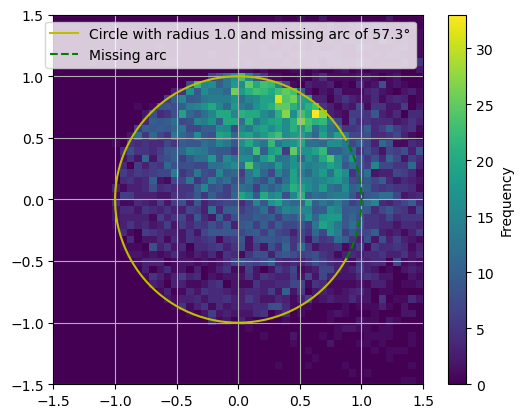

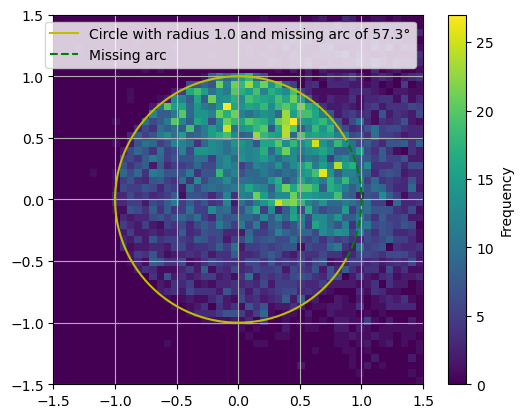

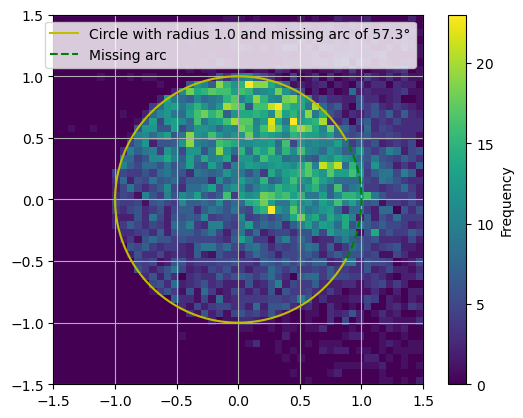

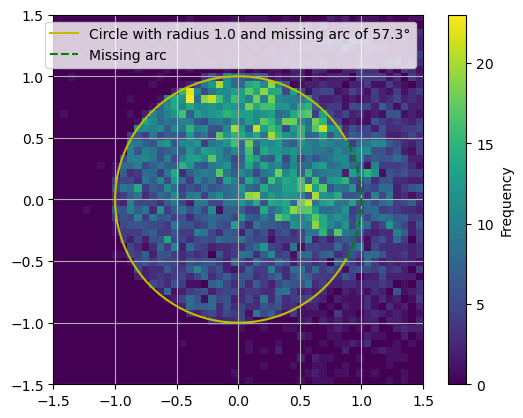

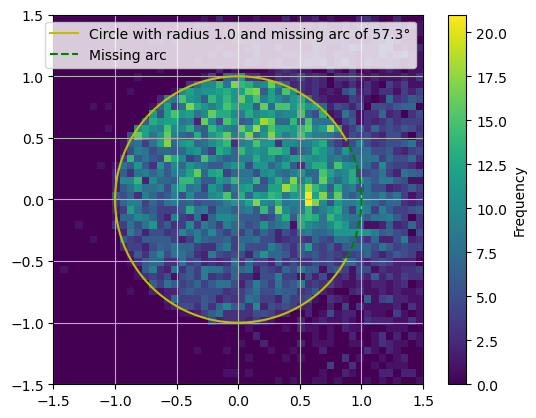

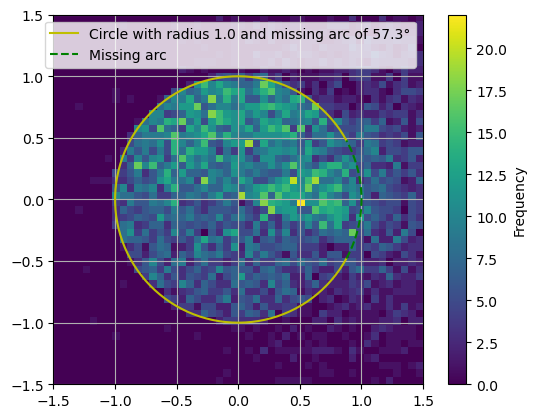

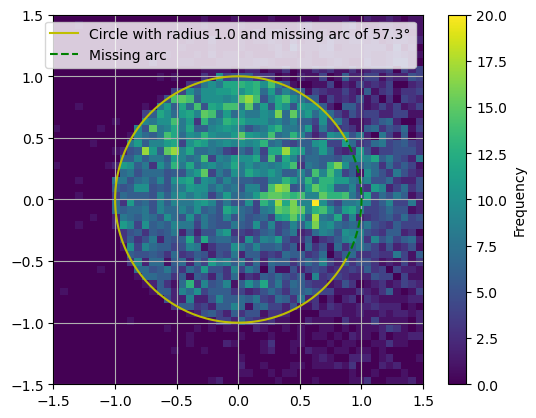

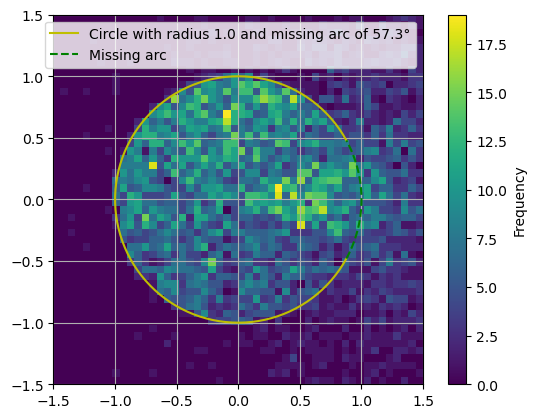

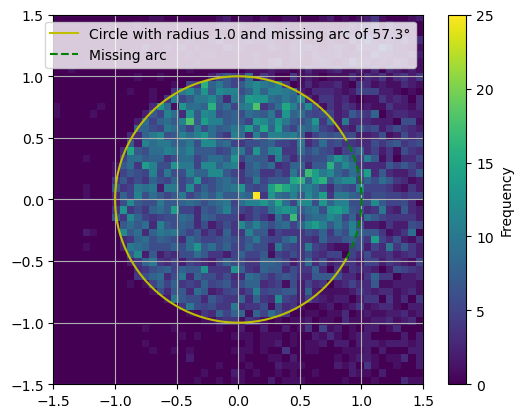

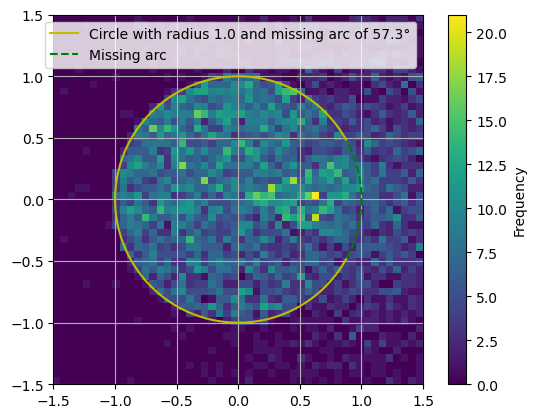

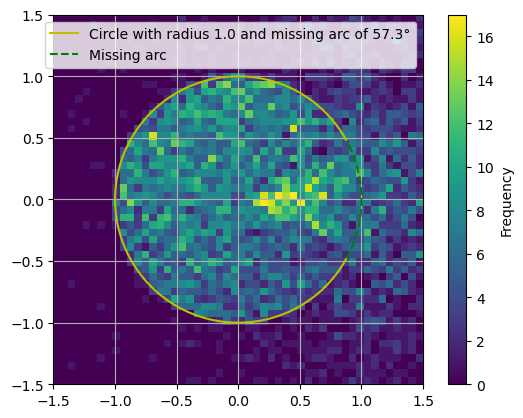

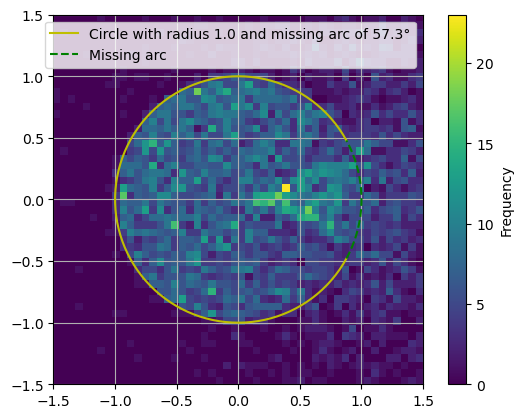

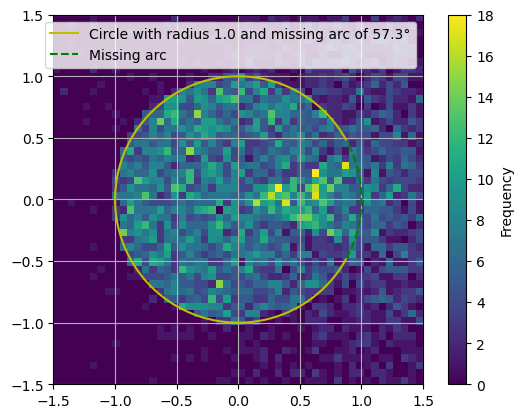

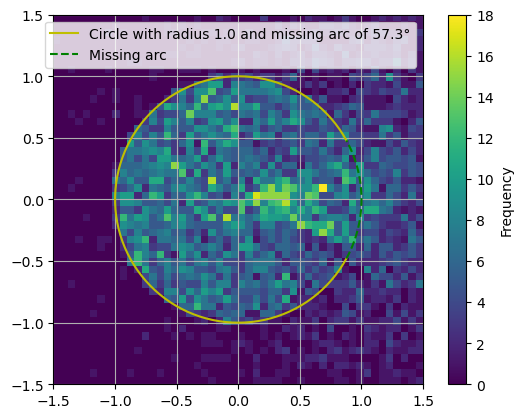

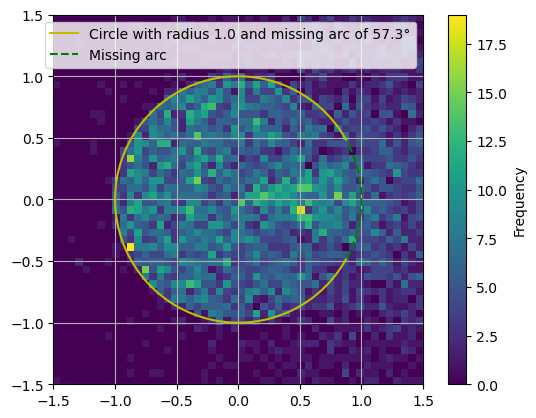

In [277]:
simulate_particle_with_snapshots(E(num_particles=10000, x_start = 0.5, y_start = 0.5), range(1, 100, 5), mode = 'heatmap')